![Logo BV IBMEC](https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/logo-bv-ibmec-notebooks.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ian-iania/IBMEC-BV-Modelos-Preditivos/blob/main/notebooks/EX1_Committee_Cutoff_NoCode.ipynb)

# EX1 — Comitê de Crédito FP&A (BV): escolha de cutoff por custo (sem programar)

- escolher cutoff (política) a partir de probabilidade de default
- justificar usando volume aprovado, perda esperada e margem/oportunidade
- entender que cenário macro e apetite de risco mudam a decisão


## Enunciado do Exercício (para grupos de 3–4 pessoas)

**Contexto:**
- Você faz parte do Comitê de Crédito e precisa decidir a política (cutoff) para negar/revisar propostas com risco de default 30+.
- O modelo prevê `P(default 30+)` para cada proposta.
- O cutoff transforma probabilidade em decisão: se `P >= cutoff` → negar/revisar; se `P < cutoff` → aprovar.
- Dois tipos de erro têm custos diferentes:
  - **FN**: aprovar quem daria default → perda (`loss_if_default`)
  - **FP**: negar bom pagador → margem/oportunidade perdida (`profit_if_good`)

**Tarefa do grupo (entregar em 3 bullets):**
1. Cutoff escolhido + % de aprovação (volume)
2. Perda esperada (R$) + margem perdida (R$) + custo total (R$)
3. Justificativa: cenário + apetite + por que o modelo (mencione 1 métrica: AUC ou PR-AUC e 1 trade-off: FN vs FP)

**Tempo sugerido:**
- 10–15 min para rodar e decidir
- 2 min para escrever os 3 bullets finais


## 🔧 Config do Grupo (NÃO precisa programar)

Escolha 3 coisas e rode o notebook. Cada grupo pode escolher combinações diferentes.


In [1]:
scenario = "BASE"            # opções: "BASE", "STRESS", "EXPANSAO"
risk_appetite = "BALANCEADO" # opções: "CONSERVADOR", "BALANCEADO", "AGRESSIVO"
chosen_model = "GBM"         # opções: "LOGISTICA", "GBM"


**Como interpretar as escolhas:**
- `BASE`: cenário normal
- `STRESS`: cenário macro pior (aumenta risco)
- `EXPANSAO`: cenário favorável (reduz risco)
- `CONSERVADOR`: FN pesa mais (prioriza reduzir perdas)
- `AGRESSIVO`: FP pesa mais (prioriza volume/margem)
- `BALANCEADO`: meio termo
- `LOGISTICA`: mais explicável (governança)
- `GBM`: costuma separar melhor (performance), com governança maior


## 1) Bibliotecas e preparação

Vamos carregar as bibliotecas usadas no exercício.


In [2]:
import pandas as pd  # manipulação de tabelas
import numpy as np  # operações numéricas
import matplotlib.pyplot as plt  # histogramas simples
import matplotlib.ticker as mtick  # formato percentual no eixo

from sklearn.compose import ColumnTransformer  # pré-processamento por tipo de coluna
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # escala e codificação
from sklearn.pipeline import Pipeline  # encadeia pré-processamento + modelo
from sklearn.linear_model import LogisticRegression  # modelo logístico
from sklearn.ensemble import GradientBoostingClassifier  # modelo GBM
from sklearn.metrics import (  # métricas de classificação
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

import plotly.graph_objects as go  # gráficos interativos multi-séries

print('Bibliotecas carregadas com sucesso.')  # confirma ambiente pronto


Bibliotecas carregadas com sucesso.


## 2) Carregar dataset do exercício

Fonte oficial (raw GitHub) em ambiente controlado.


In [3]:
url = 'https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/ex1_pf_committee.csv'  # URL oficial da base

df = pd.read_csv(url)  # lê CSV diretamente do GitHub raw

print('Fonte:', url)  # mostra origem dos dados
print(f'Shape: {df.shape[0]:,} linhas x {df.shape[1]} colunas')  # mostra tamanho da base


Fonte: https://raw.githubusercontent.com/ian-iania/IBMEC-BV-Modelos-Preditivos/main/data/ex1_pf_committee.csv
Shape: 12,000 linhas x 20 colunas


Agora vamos converter data, ordenar por tempo e ver uma amostra.


In [4]:
df['dt'] = pd.to_datetime(df['dt'])  # converte coluna de data para datetime

df = df.sort_values('dt').reset_index(drop=True)  # ordena no tempo e reinicia índice

print(f'Taxa média de default: {df["default_30p"].mean():.2%}')  # imprime taxa média da classe positiva

df.head(3)  # mostra 3 primeiras linhas da base


Taxa média de default: 10.17%


,id,dt,selic,idade,renda_mensal,score_interno,valor_solicitado,prazo_meses,taxa_mensal,parcela_mensal,pti,utilizacao_limite,atraso_antes_30d,atraso_antes_60d,canal,default_30p,ead,lgd,loss_if_default,profit_if_good
0,1,2019-01-01,6.922801,28,22989.290280,501,67670.397583,24,0.016857,3451.698320,0.150144,0.925724,0,0,digital,0,47369.278308,0.526085,24920.243160,5475.487577
1,2,2019-01-01,7.454672,36,5904.850437,604,17857.929517,48,0.014363,517.468625,0.087635,0.124067,0,0,agencia,0,12500.550662,0.250000,3125.137665,2462.306413
2,3,2019-01-01,7.073114,28,4359.502225,621,15668.297239,48,0.014492,455.281171,0.104434,0.420939,0,0,parceiro,0,10967.808067,0.562793,6172.609271,2179.837836


### Sanidade visual 1: taxa de default (barra)

**O que observar:** classe default é minoritária.


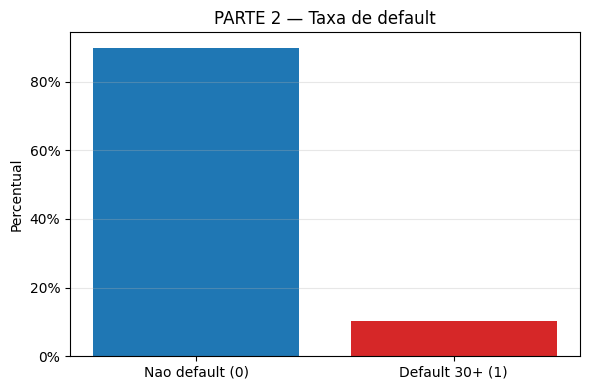

In [5]:
class_rate = df['default_30p'].value_counts(normalize=True).sort_index()  # calcula proporção de cada classe

fig, ax = plt.subplots(figsize=(6, 4))  # cria figura estática
ax.bar(['Nao default (0)', 'Default 30+ (1)'], class_rate.values, color=['#1f77b4', '#d62728'])  # plota barras
ax.set_title('PARTE 2 — Taxa de default')  # título padronizado
ax.set_ylabel('Percentual')  # eixo Y
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # formata eixo em percentual
ax.grid(axis='y', alpha=0.3)  # adiciona grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


### Sanidade visual 2: histograma de PTI

**O que observar:** distribuição de comprometimento de renda.


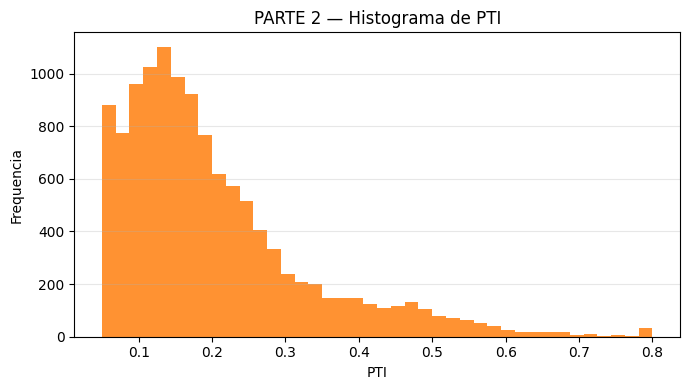

In [6]:
fig, ax = plt.subplots(figsize=(7, 4))  # cria figura do histograma de PTI
ax.hist(df['pti'], bins=40, color='#ff7f0e', alpha=0.85)  # plota distribuição de PTI
ax.set_title('PARTE 2 — Histograma de PTI')  # título padronizado
ax.set_xlabel('PTI')  # eixo X
ax.set_ylabel('Frequencia')  # eixo Y
ax.grid(axis='y', alpha=0.3)  # grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


### Sanidade visual 3: histograma de score interno

**O que observar:** concentração de score na carteira.


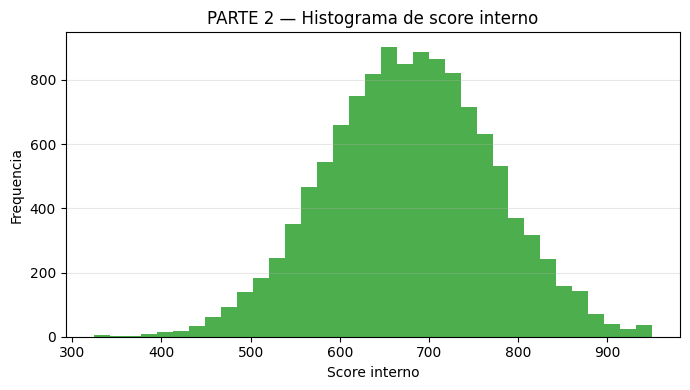

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))  # cria figura do histograma de score
ax.hist(df['score_interno'], bins=35, color='#2ca02c', alpha=0.85)  # plota distribuição de score
ax.set_title('PARTE 2 — Histograma de score interno')  # título padronizado
ax.set_xlabel('Score interno')  # eixo X
ax.set_ylabel('Frequencia')  # eixo Y
ax.grid(axis='y', alpha=0.3)  # grade horizontal
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


### Sanidade visual 4: SELIC média ao longo do tempo

**O que observar:** cenário macro evolui no tempo.


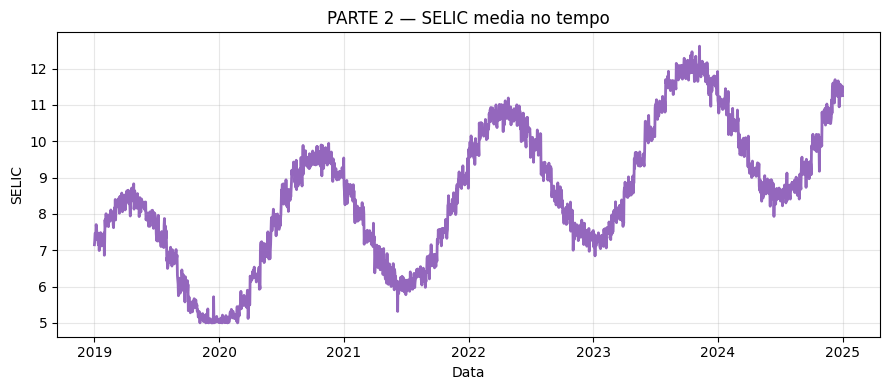

In [8]:
selic_time = df.groupby('dt', as_index=False)['selic'].mean()  # calcula SELIC média por data

fig, ax = plt.subplots(figsize=(9, 4))  # cria figura para série temporal
ax.plot(selic_time['dt'], selic_time['selic'], color='#9467bd', linewidth=2)  # plota linha da SELIC
ax.set_title('PARTE 2 — SELIC media no tempo')  # título padronizado
ax.set_xlabel('Data')  # eixo X
ax.set_ylabel('SELIC')  # eixo Y
ax.grid(alpha=0.3)  # adiciona grade
plt.tight_layout()  # ajusta layout
plt.show()  # renderiza gráfico


## 3) Split temporal (Treino/Teste)

Split 80/20 por tempo, sem embaralhar.


In [9]:
split_idx = int(len(df) * 0.8)  # calcula ponto de corte de 80%

train = df.iloc[:split_idx].copy().reset_index(drop=True)  # dados de treino (passado)
test = df.iloc[split_idx:].copy().reset_index(drop=True)  # dados de teste (futuro)

split_summary = pd.DataFrame({  # cria tabela-resumo do split temporal
    'bloco': ['treino', 'teste'],
    'linhas': [len(train), len(test)],
    'dt_inicio': [train['dt'].min().date(), test['dt'].min().date()],
    'dt_fim': [train['dt'].max().date(), test['dt'].max().date()],
    'taxa_default': [train['default_30p'].mean(), test['default_30p'].mean()],
})

split_summary['taxa_default'] = split_summary['taxa_default'].map(lambda x: f'{x:.2%}')  # formata taxa em percentual
split_summary  # exibe resumo


,bloco,linhas,dt_inicio,dt_fim,taxa_default
0,treino,9600,2019-01-01,2023-10-10,9.38%
1,teste,2400,2023-10-10,2024-12-31,13.38%


**Leitura FP&A:** essa validação simula o uso real, prevendo o futuro a partir do passado.


## 4) Treinar 2 modelos (sem tuning)

Treinaremos Logística e GBM para gerar probabilidades no TESTE.


In [10]:
num_features = [  # variáveis numéricas usadas nos modelos
    'selic',
    'idade',
    'renda_mensal',
    'score_interno',
    'valor_solicitado',
    'prazo_meses',
    'taxa_mensal',
    'parcela_mensal',
    'pti',
    'utilizacao_limite',
    'atraso_antes_30d',
    'atraso_antes_60d',
]
cat_features = ['canal']  # variável categórica para one-hot

X_train = train[num_features + cat_features].copy()  # matriz de treino
X_test = test[num_features + cat_features].copy()  # matriz de teste
y_train = train['default_30p'].copy()  # alvo treino
y_test = test['default_30p'].copy()  # alvo teste


Agora vamos definir o pré-processamento e treinar a Logística.


In [11]:
prep = ColumnTransformer(  # define tratamento por tipo de variável
    transformers=[
        ('num', StandardScaler(), num_features),  # padroniza numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),  # codifica categóricas
    ]
)

pipe_log = Pipeline(  # monta pipeline da logística
    steps=[
        ('prep', prep),
        ('model', LogisticRegression(max_iter=2000, random_state=42)),
    ]
)

pipe_log.fit(X_train, y_train)  # treina logística
proba_log = pipe_log.predict_proba(X_test)[:, 1]  # gera probabilidade no teste


Agora treinamos o GBM com o mesmo pré-processamento para comparação justa.


In [12]:
pipe_gbm = Pipeline(  # monta pipeline do GBM
    steps=[
        ('prep', prep),
        ('model', GradientBoostingClassifier(random_state=42)),
    ]
)

pipe_gbm.fit(X_train, y_train)  # treina GBM
proba_gbm = pipe_gbm.predict_proba(X_test)[:, 1]  # gera probabilidade no teste

proba_test_models = {'LOGISTICA': proba_log, 'GBM': proba_gbm}  # cria dicionário de probabilidades por modelo

print('Modelos prontos:', list(proba_test_models.keys()))  # confirma modelos disponíveis


Modelos prontos: ['LOGISTICA', 'GBM']


## 5) Aplicar cenário (sem re-treinar)

Cenário altera a economia e, portanto, o risco esperado. Aqui ajustamos as probabilidades por odds.


In [13]:
scenario_multiplier_map = {  # define multiplicadores de odds por cenário
    'BASE': 1.00,
    'STRESS': 1.35,
    'EXPANSAO': 0.85,
}

mult = scenario_multiplier_map[scenario]  # busca multiplicador do cenário escolhido

proba_base = proba_test_models[chosen_model].copy()  # seleciona probabilidade do modelo escolhido
proba_base = np.clip(proba_base, 1e-6, 1 - 1e-6)  # evita extremos para cálculo de odds

odds = proba_base / (1 - proba_base)  # converte probabilidade em odds
odds_adj = odds * mult  # aplica multiplicador de cenário nas odds
proba_test_adj = odds_adj / (1 + odds_adj)  # reconverte odds ajustadas para probabilidade

print(f'Cenario escolhido: {scenario} | multiplicador: {mult:.2f}')  # resume cenário aplicado
print(f'Media da probabilidade antes: {proba_base.mean():.4f}')  # mostra média antes do ajuste
print(f'Media da probabilidade apos : {proba_test_adj.mean():.4f}')  # mostra média após ajuste


Cenario escolhido: BASE | multiplicador: 1.00
Media da probabilidade antes: 0.1252
Media da probabilidade apos : 0.1252


**O que observar:** STRESS tende a subir probabilidade média; EXPANSAO tende a reduzir.


## 6) Definir apetite de risco (peso de FN vs FP)

Apetite muda o peso relativo das perdas por FN e da margem perdida por FP.


In [14]:
risk_weights_map = {  # define pesos de custo por apetite
    'CONSERVADOR': {'w_fn': 1.20, 'w_fp': 0.80},
    'BALANCEADO': {'w_fn': 1.00, 'w_fp': 1.00},
    'AGRESSIVO': {'w_fn': 0.90, 'w_fp': 1.20},
}

w_fn = risk_weights_map[risk_appetite]['w_fn']  # captura peso para perda de FN
w_fp = risk_weights_map[risk_appetite]['w_fp']  # captura peso para custo de FP

print(f'Apetite: {risk_appetite} | w_fn={w_fn:.2f} | w_fp={w_fp:.2f}')  # resume configuração de custo


Apetite: BALANCEADO | w_fn=1.00 | w_fp=1.00


> **Callout FP&A**  
AUC/PR-AUC medem separação (ranking), não definem a política sozinhos.


## 7) Métricas do modelo escolhido (ROC e PR)

Aqui avaliamos separação do modelo escolhido após ajuste de cenário.


In [15]:
fpr, tpr, _ = roc_curve(y_test, proba_test_adj)  # calcula pontos da curva ROC
auc_val = roc_auc_score(y_test, proba_test_adj)  # calcula AUC do modelo escolhido

fig_roc = go.Figure()  # cria figura interativa ROC
fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{chosen_model} (AUC={auc_val:.3f})'))  # curva ROC com AUC
fig_roc.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Aleatorio', line=dict(dash='dash')))  # diagonal referência
fig_roc.update_layout(  # configura layout do gráfico ROC
    title='PARTE 7 — Curva ROC (modelo escolhido)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)
fig_roc.show()  # renderiza ROC


plotly figure rendered (stub)


**Leitura:** AUC mais alta indica melhor separação entre bons e maus pagadores.


In [16]:
precision_arr, recall_arr, _ = precision_recall_curve(y_test, proba_test_adj)  # calcula pontos da curva PR
pr_auc_val = average_precision_score(y_test, proba_test_adj)  # calcula PR-AUC

fig_pr = go.Figure()  # cria figura interativa PR
fig_pr.add_trace(go.Scatter(x=recall_arr, y=precision_arr, mode='lines', name=f'{chosen_model} (PR-AUC={pr_auc_val:.3f})'))  # curva PR
fig_pr.update_layout(  # configura layout do gráfico PR
    title='PARTE 7 — Curva Precision-Recall (modelo escolhido)',
    xaxis_title='Recall',
    yaxis_title='Precision',
)
fig_pr.show()  # renderiza PR


plotly figure rendered (stub)


**Leitura:** PR-AUC é especialmente útil quando default é evento raro.


> **Callout FP&A**  
Cutoff transforma probabilidade em política (decisão).


## 8) Cutoffs didáticos (10% / 20% / 30%)

Vamos comparar três políticas simples para facilitar decisão em sala.


In [17]:
def eval_cutoff(y_true, y_proba, test_df, cutoff, w_fn, w_fp):  # avalia um cutoff e retorna métricas + custos ponderados
    y_pred = (y_proba >= cutoff).astype(int)  # converte probabilidade em decisão binária
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()  # extrai matriz de confusão

    mask_fp = (y_true.values == 0) & (y_pred == 1)  # identifica falsos positivos
    mask_fn = (y_true.values == 1) & (y_pred == 0)  # identifica falsos negativos

    custo_fp = test_df.loc[mask_fp, 'profit_if_good'].sum()  # soma margem perdida por FP
    custo_fn = test_df.loc[mask_fn, 'loss_if_default'].sum()  # soma perda por FN

    custo_total = w_fp * custo_fp + w_fn * custo_fn  # aplica pesos de apetite no custo total

    return {  # devolve resultados consolidados do cutoff
        'cutoff': cutoff,
        'aprovacao_pct': (y_pred == 0).mean(),
        'FP': int(fp),
        'FN': int(fn),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'custo_fp_R$': float(custo_fp),
        'custo_fn_R$': float(custo_fn),
        'custo_total_R$': float(custo_total),
    }


Agora aplicamos a função aos três cutoffs fixos.


In [18]:
cutoffs_fixos = [0.10, 0.20, 0.30]  # define os três cutoffs didáticos

rows_3 = [eval_cutoff(y_test, proba_test_adj, test, c, w_fn, w_fp) for c in cutoffs_fixos]  # calcula métricas para cada cutoff

cutoff_3_df = pd.DataFrame(rows_3)  # monta tabela consolidada

cutoff_3_order = cutoff_3_df.copy()  # cópia para exibição na ordem didática
for col in ['cutoff', 'aprovacao_pct', 'precision', 'recall', 'f1']:
    cutoff_3_order[col] = cutoff_3_order[col].map(lambda x: f'{x:.2%}')  # formata percentuais
for col in ['custo_fp_R$', 'custo_fn_R$', 'custo_total_R$']:
    cutoff_3_order[col] = cutoff_3_order[col].map(lambda x: f'R$ {x:,.0f}')  # formata custos

cutoff_3_order  # exibe tabela 10/20/30


,cutoff,aprovacao_pct,FP,FN,precision,recall,f1,custo_fp_R$,custo_fn_R$,custo_total_R$
0,10.00%,65.96%,590,94,27.78%,70.72%,39.89%,"R$ 1,636,064","R$ 933,776","R$ 2,569,840"
1,20.00%,83.79%,221,153,43.19%,52.34%,47.32%,"R$ 617,630","R$ 1,473,059","R$ 2,090,689"
2,30.00%,90.33%,107,196,53.88%,38.94%,45.21%,"R$ 293,324","R$ 1,849,122","R$ 2,142,446"


### Ranking por menor custo (entre 10/20/30)

**O que observar:** menor custo pode vir com menor aprovação.


In [19]:
cutoff_3_df.sort_values('custo_total_R$').reset_index(drop=True)  # mostra ranking de menor custo


,cutoff,aprovacao_pct,FP,FN,precision,recall,f1,custo_fp_R$,custo_fn_R$,custo_total_R$
0,0.2,0.837917,221,153,0.431877,0.523364,0.473239,6.176300e+05,1.473059e+06,2.090689e+06
1,0.3,0.903333,107,196,0.538793,0.389408,0.452080,2.933239e+05,1.849122e+06,2.142446e+06
2,0.1,0.659583,590,94,0.277846,0.707165,0.398946,1.636064e+06,9.337757e+05,2.569840e+06


### Custo total por cutoff (Plotly)

Visual rápido da diferença financeira entre 10%, 20% e 30%.


In [20]:
fig_cut3 = go.Figure()  # cria figura de barras para custo dos 3 cutoffs
fig_cut3.add_trace(  # adiciona barras de custo total
    go.Bar(
        x=[f'{int(c*100)}%' for c in cutoff_3_df['cutoff']],
        y=cutoff_3_df['custo_total_R$'],
        name='Custo total',
    )
)
fig_cut3.update_layout(  # configura layout do gráfico de barras
    title='PARTE 8 — Custo total nos cutoffs 10/20/30',
    xaxis_title='Cutoff',
    yaxis_title='Custo total (R$)',
)
fig_cut3.show()  # renderiza gráfico


plotly figure rendered (stub)


> **Callout FP&A**  
R$ é o payoff: FP e FN têm custos diferentes.


## 9) Grid de cutoffs (5% a 50%)

Agora vamos varrer uma faixa maior de cutoffs e encontrar o melhor por custo total.


In [21]:
cutoff_grid = np.arange(0.05, 0.51, 0.05)  # define grid de cutoffs de 5% a 50%

rows_grid = [eval_cutoff(y_test, proba_test_adj, test, c, w_fn, w_fp) for c in cutoff_grid]  # avalia todos os cutoffs

grid_df = pd.DataFrame(rows_grid)  # monta tabela completa do grid

grid_sorted = grid_df.sort_values('custo_total_R$').reset_index(drop=True)  # ordena por menor custo
best_row = grid_sorted.iloc[0].copy()  # guarda melhor linha


### Top 5 menores custos e melhor cutoff

**O que observar:** veja se a melhora de custo compensa a mudança de aprovação.


In [22]:
top5 = grid_sorted.head(5).copy()  # seleciona top 5 de menor custo

top5_fmt = top5.copy()  # cria cópia para formatação de saída
for col in ['cutoff', 'aprovacao_pct', 'precision', 'recall', 'f1']:
    top5_fmt[col] = top5_fmt[col].map(lambda x: f'{x:.2%}')  # formata colunas percentuais
for col in ['custo_fp_R$', 'custo_fn_R$', 'custo_total_R$']:
    top5_fmt[col] = top5_fmt[col].map(lambda x: f'R$ {x:,.0f}')  # formata custos em moeda

print('Melhor cutoff do grid (menor custo):')  # título curto
print(f"cutoff={best_row['cutoff']:.0%} | aprovacao={best_row['aprovacao_pct']:.2%} | custo_total=R$ {best_row['custo_total_R$']:,.0f}")  # destaca melhor cenário

top5_fmt  # exibe top 5 formatado


Melhor cutoff do grid (menor custo):
cutoff=20% | aprovacao=83.79% | custo_total=R$ 2,090,689


,cutoff,aprovacao_pct,FP,FN,precision,recall,f1,custo_fp_R$,custo_fn_R$,custo_total_R$
0,20.00%,83.79%,221,153,43.19%,52.34%,47.32%,"R$ 617,630","R$ 1,473,059","R$ 2,090,689"
1,25.00%,87.54%,155,177,48.16%,44.86%,46.45%,"R$ 443,379","R$ 1,688,842","R$ 2,132,221"
2,30.00%,90.33%,107,196,53.88%,38.94%,45.21%,"R$ 293,324","R$ 1,849,122","R$ 2,142,446"
3,35.00%,92.00%,81,210,57.81%,34.58%,43.27%,"R$ 231,734","R$ 1,969,140","R$ 2,200,874"
4,40.00%,93.29%,62,222,61.49%,30.84%,41.08%,"R$ 175,708","R$ 2,056,122","R$ 2,231,830"


### Curva custo total x cutoff (Plotly)

Trade-off principal para decisão do comitê.


In [23]:
fig_grid = go.Figure()  # cria figura de linha para custo no grid
fig_grid.add_trace(  # adiciona curva de custo total
    go.Scatter(
        x=grid_df['cutoff'],
        y=grid_df['custo_total_R$'],
        mode='lines+markers',
        name='Custo total',
    )
)
fig_grid.update_layout(  # configura layout da curva de custo
    title='PARTE 9 — Custo total (R$) vs cutoff',
    xaxis_title='Cutoff',
    yaxis_title='Custo total (R$)',
)
fig_grid.show()  # renderiza gráfico


plotly figure rendered (stub)


## 10) Gains / Lift por decil (ranking de risco)

Em crédito, ranking é uso prático: decil 1 concentra os casos mais arriscados.


In [24]:
rank_df = pd.DataFrame({  # cria base de ranking no teste
    'y_real': y_test.values,
    'proba': proba_test_adj,
})

rank_df = rank_df.sort_values('proba', ascending=False).reset_index(drop=True)  # ordena do maior para menor risco
rank_df['decil'] = pd.qcut(rank_df.index + 1, 10, labels=False) + 1  # cria 10 decis com tamanhos similares

lift_df = rank_df.groupby('decil', as_index=False).agg(  # agrega métricas por decil
    n=('y_real', 'size'),
    defaults=('y_real', 'sum'),
)

lift_df['taxa_default'] = lift_df['defaults'] / lift_df['n']  # calcula taxa de default por decil
lift_df['pct_acumulado_defaults'] = lift_df['defaults'].cumsum() / lift_df['defaults'].sum()  # calcula % acumulado de defaults


### Tabela por decil

**O que observar:** os primeiros decis devem ter taxa de default maior.


In [25]:
lift_view = lift_df.copy()  # cria cópia para formatação amigável
lift_view['taxa_default'] = lift_view['taxa_default'].map(lambda x: f'{x:.2%}')  # formata taxa de default
lift_view['pct_acumulado_defaults'] = lift_view['pct_acumulado_defaults'].map(lambda x: f'{x:.2%}')  # formata acumulado

lift_view  # exibe tabela de lift


,decil,n,defaults,taxa_default,pct_acumulado_defaults
0,1,240,127,52.92%,39.56%
1,2,240,60,25.00%,58.26%
2,3,240,31,12.92%,67.91%
3,4,240,24,10.00%,75.39%
4,5,240,22,9.17%,82.24%
5,6,240,26,10.83%,90.34%
6,7,240,9,3.75%,93.15%
7,8,240,10,4.17%,96.26%
8,9,240,9,3.75%,99.07%
9,10,240,3,1.25%,100.00%


### Barras: taxa de default por decil (Plotly)

Decil 1 = maior risco previsto.


In [26]:
fig_lift_bar = go.Figure()  # cria figura de barras para taxa por decil
fig_lift_bar.add_trace(  # adiciona barras de taxa de default
    go.Bar(
        x=lift_df['decil'],
        y=lift_df['taxa_default'],
        name='Taxa default',
    )
)
fig_lift_bar.update_layout(  # configura layout das barras
    title='PARTE 10 — Taxa de default por decil',
    xaxis_title='Decil (1 = maior risco)',
    yaxis_title='Taxa de default',
)
fig_lift_bar.show()  # renderiza gráfico


plotly figure rendered (stub)


### Linha: % acumulado de defaults capturados (Plotly)

Se o modelo separa bem, a curva sobe rápido nos primeiros decis.


In [27]:
fig_gains = go.Figure()  # cria figura de linha para ganho acumulado
fig_gains.add_trace(  # adiciona curva acumulada de defaults
    go.Scatter(
        x=lift_df['decil'],
        y=lift_df['pct_acumulado_defaults'],
        mode='lines+markers',
        name='% acumulado defaults',
    )
)
fig_gains.update_layout(  # configura layout da curva de gains
    title='PARTE 10 — Gains: % acumulado de defaults capturados',
    xaxis_title='Decil (1 = maior risco)',
    yaxis_title='% acumulado de defaults',
)
fig_gains.show()  # renderiza gráfico


plotly figure rendered (stub)


**Interpretação:** se o modelo separa bem, os primeiros decis concentram muito mais default.


## ✅ Resposta do Grupo (copiar e colar)

Preencha os 3 bullets usando os números do notebook:

- **Cutoff escolhido:** __%  | **Aprovação (volume):** __%
- **Impacto financeiro (TESTE):** perda (FN) = R$ __ | margem perdida (FP) = R$ __ | **custo total** = R$ __
- **Justificativa (3 bullets curtos):**
  1. Cenário: ____ | Apetite: ____ | Modelo: ____
  2. Métrica de separação: AUC/PR-AUC = ____ (explicar em 1 frase)
  3. Trade-off: FP vs FN (explicar por que esse cutoff equilibra custo/benefício)


## 12) Fechamento executivo

- **Modelo**: separação (AUC/PR-AUC)
- **Política**: cutoff (decisão)
- **FP&A**: custo em R$ (payoff)
- Cenário e apetite mudam o cutoff ótimo
- Logística é mais explicável; GBM pode ter performance melhor (governança maior)
